# KL divergence comparison for different numbers of simulations per round: SNPE and NIPE
### Creating figure 4.1 for thesis

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.11.0


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os


file ='toy_example_version2_maf_02_05_long'



print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_version2_maf_02_05_long


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.093
acceptance rate:  0.07354545454545454
acceptance rate:  0.07233333333333333


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.075
acceptance rate:  0.07336363636363637
acceptance rate:  0.07314285714285715
tensor([4.6186, 6.0903, 4.9335, 4.5158, 5.3863, 2.5459, 4.6741, 4.1507, 5.2809,
        5.0846, 4.1523, 3.6459, 4.8988, 3.2548, 3.0221])
tensor([ 7.1041, 10.9456, 30.1554,  9.3461, 87.4106, 54.3551, 24.4472, 26.4616,
         8.6705, 68.5198,  7.2113, 62.7640, 92.7819, 39.6656, 46.8881])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.0574, 28.4688, 61.6393,  8.4023, 15.6751,  2.0142, 12.1399,  6.8357,
         22.6869, 11.8957,  9.1419, 10.0885, 29.2427,  3.6728,  4.7430]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.011636363636363636
acceptance rate:  0.01180952380952381
acceptance rate:  0.011774193548387097
acceptance rate:  0.01175609756097561
acceptance rate:  0.012
acceptance rate:  0.01160655737704918
acceptance rate:  0.011830985915492958
acceptance rate:  0.011987654320987653
acceptance rate:  0.012131868131868132


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.016
acceptance rate:  0.012545454545454545
acceptance rate:  0.013047619047619047
acceptance rate:  0.013806451612903226
acceptance rate:  0.013390243902439024
acceptance rate:  0.013196078431372549
acceptance rate:  0.012983606557377049
acceptance rate:  0.012774647887323944
acceptance rate:  0.01297530864197531
tensor([2.5321, 3.4226, 4.6208, 4.1540, 3.6155, 2.9202, 3.1992, 2.8332, 3.8138,
        3.7928, 3.9457, 2.3107, 3.1135, 2.4398, 2.1311])
tensor([ 4.3369,  6.2286, 12.5117, 10.0385, 93.6571, 59.6070, 22.8715, 29.7670,
        11.0884, 67.6868,  7.1373, 67.7120, 95.7807, 39.8093, 44.2625])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.6704,  4.1529, 36.6824,  6.7044, 11.4379, 13.3043, 11.9769,  6.3003,
         30.5568,  8.0351,  8.1957,  2.7976,  8.3932,  1.6026,  1.2861]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.01


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 905 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.008636363636363636
acceptance rate:  0.008333333333333333
acceptance rate:  0.008741935483870967
acceptance rate:  0.008585365853658537
acceptance rate:  0.008470588235294117
acceptance rate:  0.00818032786885246
acceptance rate:  0.008126760563380282
acceptance rate:  0.008185185185185186
acceptance rate:  0.008186813186813188
acceptance rate:  0.008128712871287129
acceptance rate:  0.008045045045045045
acceptance rate:  0.008024793388429752
acceptance rate:  0.007954198473282442


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.006


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 925 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.006818181818181818
acceptance rate:  0.0067619047619047615
acceptance rate:  0.00767741935483871
acceptance rate:  0.007585365853658536
acceptance rate:  0.007705882352941176
acceptance rate:  0.00780327868852459
acceptance rate:  0.007873239436619718
acceptance rate:  0.007740740740740741
acceptance rate:  0.007747252747252747
acceptance rate:  0.007574257425742574
acceptance rate:  0.007531531531531532
acceptance rate:  0.007611570247933884
acceptance rate:  0.00749618320610687
acceptance rate:  0.00749645390070922
tensor([2.6302, 3.5293, 4.5402, 4.5602, 4.1847, 2.2753, 3.3783, 3.5663, 3.9158,
        2.5170, 4.4883, 2.8824, 3.5735, 2.3412, 2.7395])
tensor([ 4.4120,  5.8411, 18.1370, 21.5132, 92.3896, 55.5036, 30.7238, 31.5084,
         6.7760, 71.7546,  8.5030, 63.8537, 94.6853, 36.3354, 42.6316])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
te

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.084
acceptance rate:  0.08545454545454545
acceptance rate:  0.083


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.079
acceptance rate:  0.07990909090909092
acceptance rate:  0.08395238095238096
tensor([4.2963, 3.7760, 2.6077, 4.6494, 3.6846, 2.4278, 3.4625, 2.7178, 4.6788,
        2.3107, 3.9142, 2.4415, 3.1007, 2.3072, 2.1532])
tensor([ 8.7520,  7.3724, 24.0633, 16.2004, 85.9839, 57.3619, 30.4623, 26.0358,
         9.6648, 70.6905,  7.2804, 65.0519, 95.9145, 38.5203, 45.1114])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[23.8142,  6.2423, 10.1970, 27.9944, 13.0482,  4.3495, 10.2464,  2.6584,
         24.9477,  1.5705,  8.3957,  2.0374,  7.9356,  2.4204,  1.0574]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.202
acceptance rate:  0.17154545454545456


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.186
acceptance rate:  0.177
tensor([4.0968, 4.9202, 3.8748, 4.1289, 3.7801, 1.9968, 2.9433, 2.7182, 2.9329,
        3.0097, 3.5707, 2.3487, 4.2838, 2.1807, 1.9929])
tensor([ 9.4957, 13.4251, 24.8006, 11.7303, 87.4959, 54.8823, 30.0049, 25.5916,
         9.0470, 67.3240,  6.3529, 64.0602, 94.2367, 39.1228, 48.1491])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[27.5788, 37.5771, 17.1754,  8.1030,  8.4500,  0.8090,  7.2667,  3.1861,
         15.4608,  6.5078,  5.5175,  3.2858, 18.5651,  1.4829,  5.7546]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.525
acceptance rate:  0.5246363636363637


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.5
acceptance rate:  0.5257272727272727
tensor([8.0156, 5.5975, 3.0134, 3.4527, 4.1254, 2.1726, 3.1696, 3.2145, 4.6367,
        3.2476, 5.6594, 2.9717, 7.5799, 2.1058, 1.8017])
tensor([18.6658,  9.4513, 20.4353, 10.5371, 84.2431, 57.6567, 28.1283, 29.6076,
         9.8070, 68.0483, 13.6942, 61.9327, 84.4671, 36.6598, 44.6105])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[152.2515,  19.3996,   3.0319,   4.3657,  23.1633,   4.6133,   4.0062,
           6.8986,  25.5762,   5.5002,  51.5758,  11.0977, 131.8050,   6.5508,
           0.6101]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.093
acceptance rate:  0.11118181818181819


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.122
acceptance rate:  0.11109090909090909
tensor([5.1010, 3.1514, 4.2635, 6.5028, 4.2593, 2.6933, 3.6901, 4.1864, 5.7024,
        3.0765, 5.1846, 2.8434, 5.0180, 3.2544, 2.9884])
tensor([10.2322,  4.9186, 24.5840, 17.8960, 87.3474, 54.9386, 29.4241, 27.5544,
        10.4130, 67.7516, 10.5645, 60.8214, 90.3923, 44.3944, 43.6307])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[37.0329,  3.9025, 17.6453, 49.9445, 10.6398,  2.1380,  7.9409,  6.9847,
         34.5809,  5.6363, 26.7763, 15.9063, 47.5233, 13.2709,  3.8081]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.37
acceptance rate:  0.37472727272727274


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.343
acceptance rate:  0.3670909090909091
tensor([4.7978, 3.8719, 3.3411, 3.9580, 3.8626, 2.4732, 3.2440, 2.9626, 4.4265,
        2.3316, 5.4426, 2.0828, 3.8350, 1.9692, 2.0166])
tensor([10.5431,  7.2007, 21.1098, 11.6833, 86.4603, 54.9682, 31.3872, 28.7199,
        13.8659, 69.3559, 14.3315, 60.3202, 94.3621, 40.1980, 45.5983])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[37.8902,  6.3630,  4.4909,  7.3738, 11.8733,  1.6533, 13.2089,  4.2814,
         56.4778,  1.5790, 56.1553, 17.0656, 16.2645,  0.7808,  1.0109]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.003


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 938 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.005636363636363636
acceptance rate:  0.005380952380952381
acceptance rate:  0.00567741935483871
acceptance rate:  0.005292682926829269
acceptance rate:  0.0051764705882352945
acceptance rate:  0.005032786885245902
acceptance rate:  0.0050704225352112674
acceptance rate:  0.005049382716049383
acceptance rate:  0.005120879120879121
acceptance rate:  0.005207920792079208
acceptance rate:  0.005207207207207207
acceptance rate:  0.005223140495867769
acceptance rate:  0.005213740458015267
acceptance rate:  0.005170212765957447
acceptance rate:  0.00519205298013245
acceptance rate:  0.0051739130434782605
acceptance rate:  0.005175438596491228
acceptance rate:  0.005110497237569061
acceptance rate:  0.005104712041884817
acceptance rate:  0.004995024875621891


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.004


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 949 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.004636363636363636
acceptance rate:  0.004666666666666667
acceptance rate:  0.0049354838709677416
acceptance rate:  0.00475609756097561
acceptance rate:  0.004901960784313725
acceptance rate:  0.0050655737704918035
acceptance rate:  0.005084507042253521
acceptance rate:  0.005037037037037037
acceptance rate:  0.005076923076923077
acceptance rate:  0.00502970297029703
acceptance rate:  0.005009009009009009
acceptance rate:  0.004942148760330578
acceptance rate:  0.004916030534351145
acceptance rate:  0.004936170212765958
acceptance rate:  0.004940397350993378
acceptance rate:  0.004950310559006211
acceptance rate:  0.004923976608187134
acceptance rate:  0.004950276243093923
acceptance rate:  0.005020942408376964
acceptance rate:  0.005024875621890548
tensor([2.6548, 3.4767, 4.4351, 3.4785, 4.2628, 2.2382, 3.2457, 3.3088, 2.1872,
        3.0896, 3.2170, 2.6432, 4.1286, 4.0037, 2.2761])
tensor([ 4.3431,  5.4848, 18.7607, 11.8704, 91.2437, 55.1466, 24.7170, 28.0111,
   

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.114
acceptance rate:  0.10945454545454546


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.116
acceptance rate:  0.11527272727272728
tensor([3.7150, 3.5564, 3.2309, 4.5517, 4.1315, 2.1145, 3.2348, 3.2384, 4.4765,
        2.5893, 5.3537, 2.2949, 2.6579, 2.2563, 1.9933])
tensor([ 6.9881,  5.8738, 22.5655, 12.2644, 91.9850, 55.3222, 27.5970, 31.5834,
         9.5832, 69.9180, 10.1462, 63.6377, 96.2149, 40.6181, 46.2167])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.0407,  4.5633,  6.8375, 10.9073,  8.5862,  1.0387,  3.7362, 14.0724,
         23.6064,  1.9042, 25.3945,  4.0930,  5.9332,  1.4227,  1.5369]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.256
acceptance rate:  0.24472727272727274


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.258
acceptance rate:  0.24154545454545454
tensor([3.1686, 3.5515, 2.8381, 4.0159, 3.7120, 1.4822, 3.5534, 2.5957, 3.2019,
        2.8625, 4.4372, 1.9688, 2.7615, 2.2020, 2.2763])
tensor([ 6.3236,  6.6169, 18.5337, 10.1384, 91.4705, 55.7232, 29.4990, 27.7107,
         9.4905, 65.2336,  9.9685, 64.8668, 96.2851, 41.7679, 44.5343])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.8898,  4.7294,  3.5593,  6.1829,  6.1589,  0.4664,  7.6677,  2.1674,
         18.5353, 13.9044, 20.1977,  1.4028,  5.9827,  2.6977,  1.3767]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.0


                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  0.0
acceptance rate:  2.4390243902439026e-05
acceptance rate:  1.9607843137254903e-05
acceptance rate:  1.639344262295082e-05
acceptance rate:  1.4084507042253522e-05
acceptance rate:  1.2345679012345678e-05
acceptance rate:  1.0989010989010989e-05
acceptance rate:  9.900990099009901e-06
acceptance rate:  9.00900900900901e-06
acceptance rate:  1.652892561983471e-05
acceptance rate:  1.5267175572519083e-05
acceptance rate:  1.4184397163120568e-05
acceptance rate:  1.324503311258278e-05
acceptance rate:  1.2422360248447205e-05
acceptance rate:  1.7543859649122806e-05
acceptance rate:  1.6574585635359117e-05
acceptance rate:  1.5706806282722515e-05
acceptance rate:  1.4925373134328359e-05
acceptance rate:  1.4218009478672985e-05
acceptance rate:  1.3574660633484164e-05
acceptance rate:  1.2987012987012988e-05
acceptance rate:  1.2448132780082988e-05
acceptance rate:  1.1952191235059762e-05
acceptance rate:  1.1494252873563218e-

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.098
acceptance rate:  0.11227272727272727


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.115
acceptance rate:  0.11445454545454545
tensor([3.9215, 4.0454, 3.7328, 4.1643, 4.2368, 2.5592, 4.1872, 3.6352, 5.6104,
        2.6680, 4.9700, 5.2077, 3.8686, 3.6143, 2.3964])
tensor([ 6.8219,  7.3001, 20.7596, 11.8042, 85.3549, 57.3442, 27.3485, 27.0475,
        13.3975, 67.2677,  8.9540, 65.0975, 94.2120, 40.4434, 45.0110])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.1261,  7.1302,  5.4383,  8.3717, 17.8197,  4.5826,  6.8950,  4.8178,
         57.6698,  5.8103, 18.0642, 11.8171, 17.0926,  4.8450,  1.4974]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.026
acceptance rate:  0.031818181818181815
acceptance rate:  0.03061904761904762
acceptance rate:  0.030903225806451613
acceptance rate:  0.03097560975609756


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.03
acceptance rate:  0.032
acceptance rate:  0.030714285714285715
acceptance rate:  0.030903225806451613
acceptance rate:  0.030926829268292683
tensor([2.6737, 4.5247, 3.9233, 5.3121, 5.0888, 2.3542, 4.0945, 4.0015, 4.3358,
        3.2777, 4.1040, 3.1531, 3.0243, 2.4984, 2.5533])
tensor([ 4.5788,  8.2590, 23.5293, 13.0116, 86.8450, 56.4462, 26.8399, 28.3299,
        10.1076, 66.7731,  8.3310, 66.8980, 96.1042, 39.3600, 46.1335])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.3370, 10.7785, 12.0575, 16.4742, 15.7979,  2.4606,  6.4858,  7.0037,
         26.0839,  8.8908, 12.0572,  3.7260,  7.1594,  1.9102,  2.4647]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.034
acceptance rate:  0.03590909090909091
acceptance rate:  0.0360952380952381
acceptance rate:  0.036096774193548384


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.036
acceptance rate:  0.03881818181818182
acceptance rate:  0.038285714285714284
acceptance rate:  0.037516129032258067
tensor([6.0344, 4.8941, 5.8780, 4.0857, 4.8711, 3.1276, 3.6229, 4.4602, 4.0164,
        4.2698, 4.1525, 2.6851, 3.1156, 2.9553, 2.3751])
tensor([15.0634, 10.8120, 25.4709, 10.3436, 85.0777, 54.7500, 27.8655, 27.7216,
         7.6664, 69.8953,  6.7583, 63.2053, 96.3344, 35.9987, 44.5020])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[88.6721, 21.4661, 29.9700,  6.4978, 21.8948,  3.2820,  5.1499,  8.2118,
         12.8965,  7.1694,  8.2436,  6.0224,  6.7697, 10.7887,  1.5796]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.244
acceptance rate:  0.2575454545454545


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.262
acceptance rate:  0.2571818181818182
tensor([4.3296, 3.3909, 2.9917, 3.9003, 3.3334, 1.9608, 3.2088, 2.8019, 3.7066,
        2.8688, 3.2426, 3.0166, 3.3667, 2.6342, 2.0646])
tensor([11.3266,  6.5459, 21.5068,  9.6915, 90.0717, 53.1813, 24.9252, 28.9736,
        10.0126, 67.6270,  6.6359, 64.9062, 95.3082, 39.4902, 43.5959])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[42.0735,  4.1771,  4.0145,  5.7927,  3.8544,  2.4029,  5.6347,  4.3425,
         23.1353,  5.3765,  4.9190,  3.5439, 10.7680,  2.1308,  1.8920]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.462
acceptance rate:  0.43872727272727274


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.452
acceptance rate:  0.44163636363636366
tensor([3.6524, 4.1713, 3.2347, 3.5495, 2.9337, 1.9703, 3.4713, 2.9962, 3.7340,
        2.4220, 3.9201, 2.6625, 4.8791, 2.0986, 1.5735])
tensor([ 6.4119,  9.0738, 24.9562, 11.1532, 91.8482, 56.1655, 26.8827, 30.4320,
         8.1196, 68.6225, 11.3586, 62.6495, 88.3447, 39.9881, 48.6750])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[10.6950, 11.4958, 15.8396,  5.1975,  4.4349,  1.4421,  4.2872,  8.7804,
         13.6392,  2.4972, 26.0333,  7.6780, 66.5861,  0.9608,  7.0375]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.271
acceptance rate:  0.2561818181818182


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.261
acceptance rate:  0.2549090909090909
tensor([4.0479, 3.3983, 2.5923, 2.5922, 3.9740, 1.7916, 2.3787, 2.6361, 3.0199,
        2.3363, 2.8131, 2.2500, 4.3594, 1.6496, 1.3301])
tensor([ 7.4281, 10.3834, 24.0919, 11.7617, 83.2622, 57.0830, 25.5714, 29.8130,
         7.1390, 69.2080,  5.1623, 61.5351, 93.0554, 40.7346, 44.9513])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[16.0985, 13.6577, 10.2793,  3.4590, 28.7156,  2.6912,  2.4831,  5.9616,
          7.8814,  1.6941,  2.4356, 11.1880, 25.1992,  0.6299,  0.1005]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.064
acceptance rate:  0.07809090909090909
acceptance rate:  0.07976190476190476


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.078
acceptance rate:  0.08527272727272728
acceptance rate:  0.08404761904761905
tensor([5.4052, 5.6146, 4.1114, 4.9897, 6.2068, 3.6014, 3.6372, 4.4342, 5.5430,
        3.0691, 7.0586, 3.5847, 4.3894, 2.7221, 3.5590])
tensor([ 7.9603, 17.9359, 20.0784,  7.9464, 85.9162, 52.7368, 27.9937, 23.3552,
        14.0551, 66.9360, 15.7723, 64.2479, 93.9508, 39.2445, 40.0280])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[24.7232, 84.7693,  6.5409, 12.4497, 25.2754,  7.2646,  5.3172, 14.4840,
         63.7023,  7.7823, 80.4783,  6.1832, 20.4013,  2.4888, 16.9242]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.245
acceptance rate:  0.25018181818181817


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.263
acceptance rate:  0.256
tensor([3.4983, 4.0595, 3.2721, 3.9511, 3.8147, 1.8405, 3.1624, 2.7596, 4.4537,
        2.4988, 4.7947, 2.7079, 3.1465, 2.2846, 2.3770])
tensor([ 6.4297,  8.8960, 22.0854, 13.5380, 86.1871, 55.2117, 25.4990, 32.2466,
        10.2484, 67.5995, 10.5825, 64.4664, 95.9146, 39.1197, 47.2032])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[10.2483, 10.5321,  5.8425, 12.1902, 12.7063,  0.6061,  4.4756, 16.0558,
         27.4453,  4.5873, 25.0089,  3.3461,  8.0638,  1.6710,  3.8862]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.16
acceptance rate:  0.1740909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.165
acceptance rate:  0.17472727272727273
tensor([4.5132, 4.6761, 4.1233, 3.7419, 3.5159, 2.8594, 3.6625, 3.5635, 4.5306,
        3.1239, 4.7086, 3.4221, 4.5601, 1.9684, 2.4780])
tensor([ 8.6496, 14.6279, 25.6348,  6.4963, 91.2540, 56.9025, 29.1852, 29.2199,
         8.5546, 71.3609,  7.7602, 64.7474, 91.0465, 40.6433, 50.5518])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[24.1364, 46.1106, 22.4597, 11.3191,  5.2098,  4.3472,  7.2961,  7.0426,
         18.6241,  4.1662, 12.8455,  4.9096, 40.0086,  0.9669, 17.0743]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.039
acceptance rate:  0.03109090909090909
acceptance rate:  0.029619047619047618
acceptance rate:  0.03038709677419355
acceptance rate:  0.030292682926829267


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.031
acceptance rate:  0.029818181818181817
acceptance rate:  0.02942857142857143
acceptance rate:  0.029548387096774195
acceptance rate:  0.0294390243902439
tensor([3.4248, 5.4301, 3.2083, 3.6154, 3.5919, 2.3324, 2.7733, 3.3010, 4.2689,
        2.9609, 3.1828, 2.4410, 2.6617, 2.5598, 1.8472])
tensor([ 5.6964, 11.4600, 21.4960, 13.8379, 90.4719, 55.7408, 28.5684, 26.3281,
         8.6652, 66.3173,  6.2780, 64.1312, 96.7308, 40.0020, 43.3042])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 7.7689, 27.4566,  4.5998, 12.1154,  4.7836,  1.6475,  3.5554,  3.9799,
         18.0421,  9.5791,  4.2239,  3.3330,  4.6381,  1.8364,  2.0302]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.287
acceptance rate:  0.29245454545454547


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.279
acceptance rate:  0.285
tensor([3.8914, 3.2450, 2.6356, 7.5083, 3.3658, 2.1608, 3.2406, 2.9543, 4.9207,
        2.1421, 3.1974, 2.1405, 2.6737, 2.0464, 2.0629])
tensor([ 7.0272,  6.6736, 25.3579, 24.1985, 86.0396, 54.2114, 30.0858, 27.9682,
        12.2466, 67.6527,  9.8163, 66.9753, 96.2788, 37.9547, 47.4448])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 13.8219,   3.8149,  16.3578, 126.4703,  11.7933,   1.3750,   8.3362,
           3.2494,  44.0169,   3.7873,  15.0475,   1.5054,   5.7933,   2.9694,
           3.8922]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.092
acceptance rate:  0.09018181818181818
acceptance rate:  0.08938095238095238


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.094
acceptance rate:  0.08981818181818182
acceptance rate:  0.09133333333333334
tensor([3.5274, 1.9549, 3.0379, 2.7692, 3.4593, 1.6485, 1.8988, 2.2979, 3.6455,
        2.1287, 2.9823, 1.7260, 2.2388, 1.2403, 1.6106])
tensor([ 8.8170,  3.6432, 19.2244,  8.8932, 88.9138, 55.2685, 24.5641, 28.9526,
         9.6234, 69.5646,  5.7415, 63.7450, 97.0599, 40.2156, 44.2177])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[21.3795,  3.5178,  3.3041,  2.9283,  4.8323,  0.3949,  3.6283,  3.2146,
         20.6631,  1.1049,  3.1292,  2.9862,  3.0822,  0.0770,  0.6264]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.101
acceptance rate:  0.10518181818181818


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.108
acceptance rate:  0.10618181818181818
tensor([3.7103, 4.3343, 3.8728, 4.3539, 3.9113, 3.3818, 3.9794, 3.8061, 4.8825,
        3.4082, 4.9281, 3.0195, 3.9699, 2.9194, 2.5669])
tensor([ 6.0433,  8.9888, 26.1577, 16.7651, 93.3493, 58.1981, 25.0950, 21.8058,
         9.1376, 68.8050, 11.3393, 65.4684, 94.5429, 38.3798, 44.8172])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.7028, 11.8931, 24.6038, 30.3908, 11.3943,  9.1136,  7.8511, 18.8965,
         23.0313,  4.7958, 30.1416,  3.0948, 15.9341,  4.0026,  1.8686]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.016
acceptance rate:  0.018363636363636363
acceptance rate:  0.017761904761904763
acceptance rate:  0.017838709677419354
acceptance rate:  0.017756097560975608
acceptance rate:  0.017529411764705884
acceptance rate:  0.017491803278688524


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014
acceptance rate:  0.01709090909090909
acceptance rate:  0.01804761904761905
acceptance rate:  0.017806451612903226
acceptance rate:  0.018024390243902438
acceptance rate:  0.018313725490196078
acceptance rate:  0.018508196721311477
tensor([4.6281, 3.3558, 3.7631, 3.7991, 5.2504, 2.9246, 2.9464, 3.2586, 3.3606,
        3.4534, 4.0440, 3.3786, 4.2185, 2.7648, 2.5168])
tensor([ 9.2903,  5.4363, 24.0636,  8.6824, 88.1886, 55.3926, 26.4865, 30.4755,
         5.3181, 68.1744,  8.0332, 68.0944, 94.0643, 41.8379, 50.7937])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[28.4611,  4.0790, 13.5116,  6.2497, 13.2656,  2.7807,  2.8919,  9.6674,
          4.8033,  5.8900, 10.8799,  6.1832, 19.1388,  3.9940, 18.5276]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.356
acceptance rate:  0.3420909090909091


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.365
acceptance rate:  0.3488181818181818
tensor([5.1760, 5.8083, 4.4507, 4.7494, 4.6099, 2.4988, 2.5859, 3.7823, 3.3368,
        3.5493, 4.6633, 3.1376, 3.1428, 2.4454, 2.4422])
tensor([ 9.8744, 11.0891, 24.9335, 11.1707, 83.9735, 57.7990, 31.1128, 30.8592,
         7.0630, 65.5568, 14.8144, 63.9888, 95.0774, 42.5308, 46.2014])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[34.8806, 27.5586, 20.0812,  9.9057, 26.7570,  5.6236, 10.3512, 12.7694,
          8.5530, 14.4030, 56.9943,  5.3011, 10.9867,  4.7982,  2.3110]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.014


                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 891 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


acceptance rate:  0.009909090909090909
acceptance rate:  0.009476190476190477
acceptance rate:  0.010096774193548387
acceptance rate:  0.01002439024390244
acceptance rate:  0.010176470588235294
acceptance rate:  0.010311475409836065
acceptance rate:  0.010704225352112675
acceptance rate:  0.01074074074074074
acceptance rate:  0.010483516483516484
acceptance rate:  0.010594059405940595


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.012
acceptance rate:  0.010818181818181819
acceptance rate:  0.01042857142857143
acceptance rate:  0.010096774193548387
acceptance rate:  0.010585365853658537
acceptance rate:  0.010392156862745097
acceptance rate:  0.010491803278688525
acceptance rate:  0.010873239436619718
acceptance rate:  0.010728395061728395
acceptance rate:  0.010692307692307692
acceptance rate:  0.010633663366336634
tensor([3.5102, 5.1765, 3.3539, 4.5739, 5.2436, 2.6520, 4.0636, 3.3127, 3.2207,
        3.5474, 3.2993, 3.0899, 5.6025, 2.3495, 2.5253])
tensor([ 6.0893,  8.2672, 22.5721, 11.9896, 87.8618, 56.3840, 26.1076, 28.2770,
         5.4723, 71.5009,  6.2584, 63.4927, 91.9641, 40.3449, 43.8967])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.1771, 13.8240,  7.2222, 10.4193, 13.8768,  2.9989,  6.7526,  4.6047,
          4.6005,  5.6520,  4.5408,  6.2887, 38.223

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.301
acceptance rate:  0.2933636363636364


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.287
acceptance rate:  0.2907272727272727
tensor([4.5927, 5.3228, 3.4695, 4.2633, 3.4162, 2.6007, 2.9824, 2.8728, 4.2157,
        2.3795, 6.3367, 2.1475, 3.4814, 2.4421, 1.8142])
tensor([ 8.6158, 15.6382, 26.5613, 14.3686, 86.6150, 55.5671, 26.5817, 26.4857,
         9.2402, 66.7442, 19.3005, 64.9278, 95.3884, 40.7538, 47.0570])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 24.2906,  58.4419,  25.8001,  16.6804,   9.8357,   2.0868,   2.9422,
           2.7034,  20.6773,   6.7642, 119.9826,   1.6163,  10.8343,   1.8731,
           2.6658]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.104
acceptance rate:  0.11036363636363636


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.12
acceptance rate:  0.12181818181818181
tensor([2.8000, 2.9961, 3.9177, 3.4922, 3.5593, 2.2158, 2.8232, 2.5300, 3.5261,
        3.3227, 3.4862, 3.0960, 5.8469, 2.7275, 1.6090])
tensor([ 4.9601,  5.8769, 24.0153, 14.5757, 88.4132, 56.4587, 28.6408, 31.8065,
         8.2745, 65.4699,  5.8728, 63.6508, 90.2690, 38.3364, 45.9891])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.3115,  2.8985, 13.8700, 14.8155,  5.8236,  2.2233,  3.7934, 13.3237,
         13.5921, 14.0804,  4.7087,  5.9218, 52.9428,  3.6001,  0.8080]])


In [13]:
torch.save(overall_snpe_list, 'overall_snpe_list.pt')

In [14]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [15]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [16]:
import seaborn as sns

In [17]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [18]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

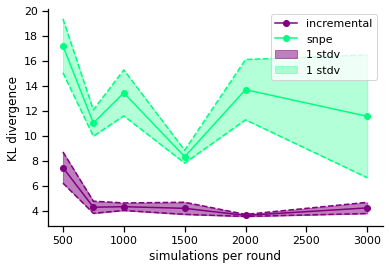

In [19]:
sns.set_context('notebook')
#sns.set_context('talk')

plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='purple')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='springgreen')

plt.plot(num_simulations_list, upper_incremental, '--', color='purple')
plt.plot(num_simulations_list, upper_snpe, '--',  color='springgreen')

plt.plot(num_simulations_list, lower_incremental, '--',  color='purple')
plt.plot(num_simulations_list, lower_snpe, '--',  color='springgreen')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='purple', alpha=0.5,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='springgreen', alpha=0.3, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()
sns.despine()

